### Preprocess the data and store
This notebook calculates the ice water fraction, cloud top and winddirection from a raw output netcdf file from a WRF simulation.
Output is stored to a folder, and later used as input to SpatialAlgorithm and TemporalAlgorithm.

This greatly reduces the size of the data, and saves computing power and time.

In [1]:
import xarray as xr
import numpy as np, matplotlib.pyplot as plt
import wrf
from datetime import datetime, timedelta
import cartopy.crs as ccrs

# Path to data locations
MAS3_path = '/nird/projects/NS9600K/brittsc/230612_Morr5_without_NNUCCR/wrfout_d03_2019-11-11_12:00:00'
MD3_path = '/nird/projects/NS9600K/brittsc/211108_WRF_NYA/wrfout_d03_2019-11-11_12:00:00'

MD3_HR_paths = ['/nird/projects/NS9600K/brittsc/240312_Morr_default_high_time_res_output/wrfout_d03_2019-11-11_12:00:00',
                '/nird/projects/NS9600K/brittsc/240312_Morr_default_high_time_res_output/wrfout_d03_2019-11-12_04:40:00',
                '/nird/projects/NS9600K/brittsc/240312_Morr_default_high_time_res_output/wrfout_d03_2019-11-12_21:20:00']

MA3_HR_paths = ['/nird/projects/NS9600K/brittsc/240311_Morr2_high_time_res_output/wrfout_d03_2019-11-11_22:00:00',
                '/nird/projects/NS9600K/brittsc/240311_Morr2_high_time_res_output/wrfout_d03_2019-11-12_08:00:00',
                '/nird/projects/NS9600K/brittsc/240311_Morr2_high_time_res_output/wrfout_d03_2019-11-12_18:00:00']

MAS3_HR_paths = ['/nird/projects/NS9600K/brittsc/240203_Morr5_corrected_SST_high_time_res_output/wrfout_d03_2019-11-11_22:00:00',
                '/nird/projects/NS9600K/brittsc/240203_Morr5_corrected_SST_high_time_res_output/wrfout_d03_2019-11-12_08:00:00',
                '/nird/projects/NS9600K/brittsc/240203_Morr5_corrected_SST_high_time_res_output/wrfout_d03_2019-11-12_18:00:00']

In [2]:
def processed_wrf(model_path, cut_edges=10, tslice=None, hslice=slice(0, 85)):
    '''
    Prepare, reduce, and concatenate data from high resolution WRF simulation(s). 
    Takes a path (or list of paths if output is split into several files) with location of raw output from WRF
    
    Arguments:
    model_path  (str or list)                  - path to location of WRF raw output. If model_path is type 'list', 
                                                 outputs are concatenated in time as single xarray Dataset object
    cut_edges   (int)                          - number of outermost grid cells from each side to exclude from analysis. Default is 10
    tslice      (None, slice or list of slice) - if not None, slice object of time steps to include from (each) WRF simulation
    hslice      (slice)                        - slice object of the model levels to include in analysis

    Returns:
    xarray Dataset object containing wrf simulated IWF, wind direction and cloud top, after applying a cloud mask requirement of >50% 
    '''
        
    xslice = yslice = slice(cut_edges, 100 - cut_edges)
    
    def calculate(path, tslice):
        M = xr.open_dataset(path).isel(west_east=xslice, south_north=yslice, bottom_top=hslice, 
                                        west_east_stag=xslice, south_north_stag=yslice, bottom_top_stag=hslice, 
                                        Time=tslice)
        
        # Find Cloud Top
        hc = xr.where(M.CLDFRA >= 0.5, x=M.bottom_top, y=0)
        CT = hc.argmax(dim='bottom_top')
        del hc

        # Compute the ICE and LIQUID contents
        ICE = M.QICE + M.QGRAUP + M.QSNOW
        LIQUID = M.QRAIN + M.QCLOUD
        #TOTAL = ICE + LIQUID

        # Find the Ice and Liquid at cloud top levels
        #ICE = ICE.where(ICE.bottom_top <= CT, other=np.nan)
        #LIQUID = LIQUID.where(LIQUID.bottom_top <= CT, other=np.nan)

        
        # Compute the fraction of mean ice to mean total condensate at cloud top levels
        IWF = (ICE / (ICE + LIQUID))#.mean(dim='bottom_top')
        #IWF = IWF.where(M.CLDFRA > 0.5, other=np.nan)
        #IWF_classified = xr.where((IWF < 0.9) & (IWF > 0.1), x=0.5, y=IWF)
        #IWF_classified = xr.where(IWF > 0.9, x=1, y=IWF_classified)
        #IWF_classified = xr.where(IWF < 0.1, x=0, y=IWF_classified).T * 2
        #del IWF, ICE, LIQUID

        # Compute the (spatial) mean wind direction at cloud top
        meanCT = CT.mean(dim=['west_east', 'south_north']).astype(int)
        U = M.U.isel(bottom_top=meanCT).mean(dim=['west_east_stag', 'south_north'])
        V = M.V.isel(bottom_top=meanCT).mean(dim=['west_east', 'south_north_stag'])
    
        winddir = 90 - np.rad2deg(np.arctan(V / U)) # Fixed 13/03/24 to align with transect angle as defined by wrf.interpline (0deg=S-N)

        return xr.Dataset(data_vars={'IWF': IWF, 'CT': CT, 'winddir': winddir})


    if type(model_path) == str:
        if tslice is None:
            tslice = slice(144, None)
        return calculate(model_path, tslice)
    else:
        if tslice is None:
            tslices = [slice(120, None), slice(None, None), slice(None, None)]
        else:
            tslices = [slice(tslice[0], None), slice(None, None), slice(None, tslice[1])]
        return xr.concat([calculate(path, t) for path, t in zip(model_path, tslices)], dim='Time')


In [10]:
del MA3
MAS3 = xr.map_blocks(processed_wrf, MAS3_HR_paths).compute()
MAS3.to_netcdf('/nird/projects/NS9600K/sldam/data/processed_data_no_threshold/MAS3_HighRes_12Nov_IWF_CT_winddir.nc')

#MD3 = xr.map_blocks(processed_wrf, MD3_HR_paths, kwargs={'tslice': (720, None)}).compute()
#MD3.to_netcdf('/nird/projects/NS9600K/sldam/data/processed_data_no_threshold/MD3_HighRes_12Nov_IWF_CT_winddir.nc')

#MA3 = xr.map_blocks(processed_wrf, MA3_HR_paths, kwargs={'tslice': (120, None)}).compute()
#MA3.to_netcdf('/nird/projects/NS9600K/sldam/data/processed_data_no_threshold/MA3_HighRes_12Nov_IWF_CT_winddir.nc')

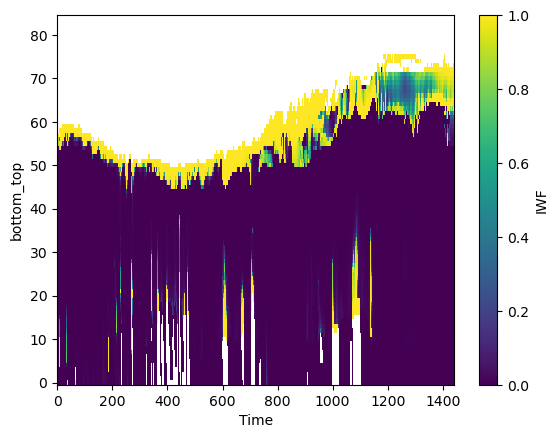

In [9]:
MA3.IWF.isel(south_north=50, west_east=43).T.plot()